# Movie Lens Recommendation Systems

**Authors:** Tony Bai, Eddie Lin, Douglas Lu, Shane Mangold
***

## Overview

In this project we will aim to explore different types of recommendation systems

## Business Problem
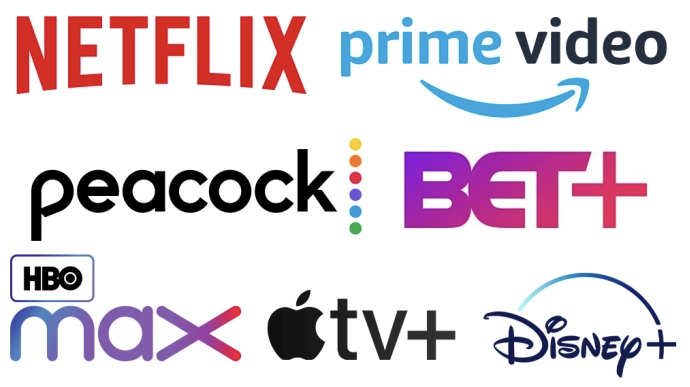

Every Recommendation System these days wether its Hulu, Netflix or Prime Video, are limited only to those movies that 
are contained in each application. We aim to build a third party movie recommender that can take a title and recommend you similar movies that are not limited to a streaming platform
***
***

## Data Understanding



In [1]:
# Import standard packages
import pandas as pd
import numpy as np
from sklearn.metrics import pairwise_distances
from surprise import Reader, Dataset, accuracy, SVDpp
from surprise.model_selection import cross_validate, GridSearchCV, train_test_split
from surprise.prediction_algorithms import SVD, KNNWithMeans, KNNBasic, KNNBaseline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
%matplotlib inline

In [4]:
from Code import func, viz

ModuleNotFoundError: No module named 'Code'

In [3]:
viz.viz_1()

NameError: name 'viz' is not defined

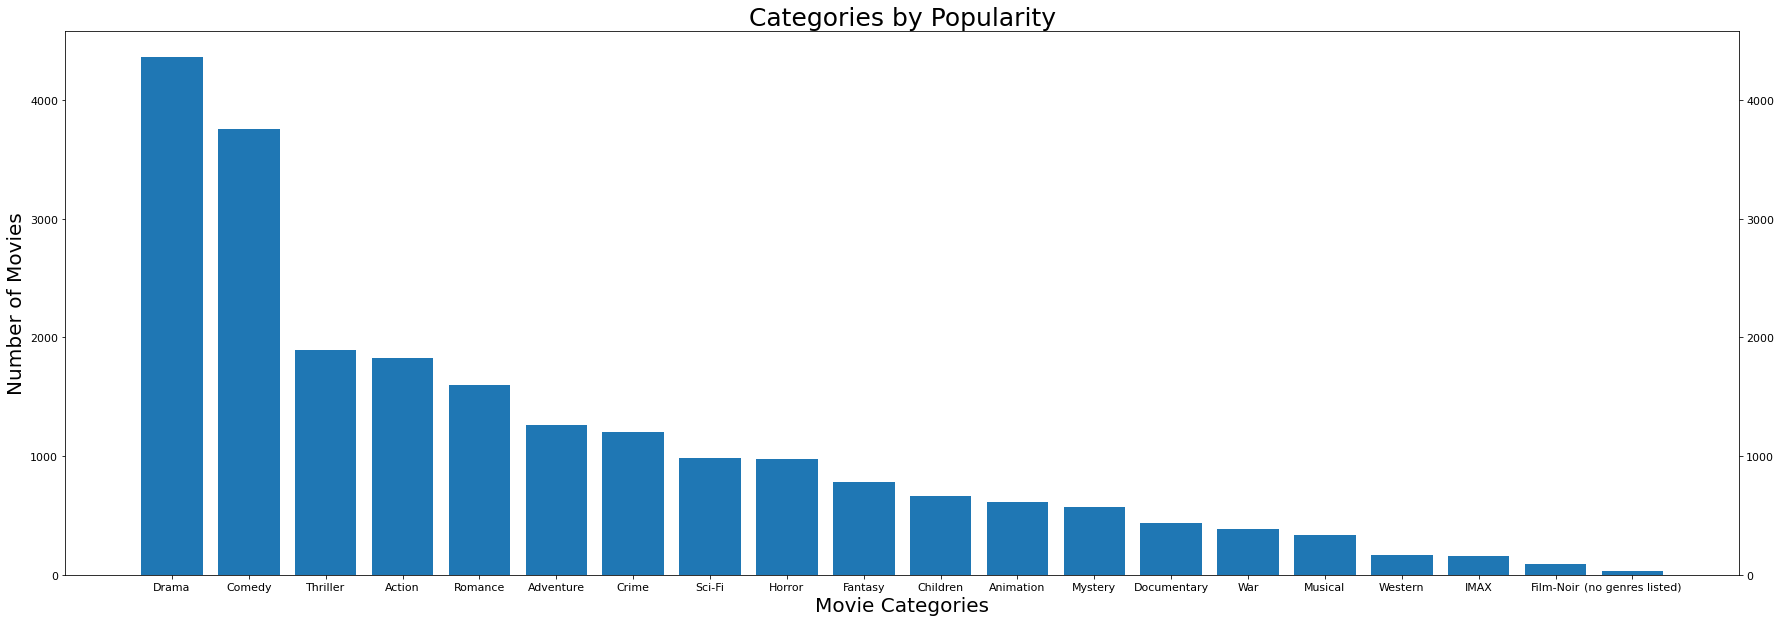

In [4]:
viz.viz_2()

## Data Preparation

Describe and justify the process for preparing the data for analysis.

***
Questions to consider:
* Were there variables you dropped or created?
* How did you address missing values or outliers?
* Why are these choices appropriate given the data and the business problem?
***

In [5]:
movies = pd.read_csv('Data/movies.csv')
ratings = pd.read_csv('Data/ratings.csv')

In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [7]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [9]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [10]:
df_joined = pd.merge(ratings, movies)

In [11]:
reader = Reader(rating_scale=(0.5, 5.0))
data = Dataset.load_from_df(ratings[['movieId', 'userId', 'rating']], reader)

## Data Modeling
Describe and justify the process for analyzing or modeling the data.

***
Questions to consider:
* How did you analyze or model the data?
* How did you iterate on your initial approach to make it better?
* Why are these choices appropriate given the data and the business problem?
***

## KNearest Neighbors Baseline Model

In [ ]:
#Where are the scores for this one?
knn_baseline = KNNBaseline(sim_options={'name':'pearson', 'user_based':True})
cv_knn_baseline = cross_validate(knn_baseline,data)

Estimating biases using als...


In [ ]:
for i in cv_knn_baseline.items():
    print(i)

np.mean(cv_knn_baseline['test_rmse'])

## SVD with Surprise

In [ ]:
#what is this for? I dont see it being used.
dataset = data.build_full_trainset()

In [ ]:
#need to add more to the grid search later
params = {'n_factors': [20, 50, 100],
         'reg_all': [0.02, 0.05, 0.1]}
g_s_svd = GridSearchCV(SVD,param_grid=params,n_jobs=-1)

#Why are we fitting to our full data and not just the training data??
g_s_svd.fit(data)


print(g_s_svd.best_score)
print(g_s_svd.best_params)

## SVD++ with Surprise

In [ ]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=.2)

In [ ]:
algo_svdpp = SVDpp(n_factors=150, n_epochs=8, lr_all=0.005, reg_all=0.1)
algo_svdpp.fit(trainset)
test_pred = algo_svdpp.test(testset)
print("SVDpp : Test Set")
accuracy.rmse(test_pred, verbose=True)

In [ ]:
#Whats going on here?
df_2 = df_joined.groupby('title')["userId","rating"].count()[lambda x: x> 1].sort_values(by = "rating", ascending = False)
df_2 = df_joined.groupby(['title','rating']).count()["userId"][lambda x: x> 1].sort_values(ascending = False)
df_3=df_joined.drop('timestamp', axis=1)
df_3= df_3.groupby('movieId').agg([np.size, np.mean])
a= df_3['userId']['size'] ==1
a.value_counts()

## Cold Start Model with SVD

In [ ]:
#Is this the cold start model??
df_joined.drop(['userId', 'timestamp','rating'], axis=1)

In [ ]:
user_rating = func.movie_rater(df_joined, 3, 'Action')

In [ ]:
df_new = df_joined.drop(['genres','title','timestamp'], axis=1)
new_ratings = df_new.append(user_rating,ignore_index=True)
new_data = Dataset.load_from_df(new_ratings, reader)

In [ ]:
svd_ = SVD(n_factors= 50, reg_all=0.05)
svd_.fit(new_data.build_full_trainset())

In [ ]:
list_of_movies = []
for m_id in df_new['movieId'].unique():
    list_of_movies.append( (m_id,svd_.predict(1000,m_id)[3]))

In [ ]:
list_of_movies[:5]

In [ ]:
ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)

In [19]:
ranked_movies[:5]

[(318, 4.701694168845271),
 (750, 4.672865445831006),
 (3275, 4.605341098225822),
 (1221, 4.596951589074909),
 (1104, 4.596781429993833)]

In [21]:
func.recommended_movies(ranked_movies,movies,4)

Recommendation #  1 :  277    Shawshank Redemption, The (1994)
Name: title, dtype: object 

Recommendation #  2 :  602    Dr. Strangelove or: How I Learned to Stop Worr...
Name: title, dtype: object 

Recommendation #  3 :  2462    Boondock Saints, The (2000)
Name: title, dtype: object 

Recommendation #  4 :  922    Godfather: Part II, The (1974)
Name: title, dtype: object 



## Content based Filtering

In [22]:
# Define a TF-IDF Vectorizer Object.
tfidf_movies_genres = TfidfVectorizer(token_pattern = '[a-zA-Z0-9\-]+')
tfidf_movies_genres_matrix = tfidf_movies_genres.fit_transform(movies['genres'])
cosine_score = linear_kernel(tfidf_movies_genres_matrix, tfidf_movies_genres_matrix)

In [25]:
#fixed
func.get_recommendations_based_on_genres('Steamboat Willie (1928)')

1543                       Jungle Book, The (1967)
3727         Ferngully: The Last Rainforest (1992)
5232    Claymation Christmas Celebration, A (1987)
Name: title, dtype: object

In [27]:
#fixed
func.get_recommendation_content_model(4)

{'13 Tzameti (2005)',
 '39 Steps, The (1935)',
 '3:10 to Yuma (1957)',
 '52 Pick-Up (1986)',
 '7 Faces of Dr. Lao (1964)',
 'Ace Ventura: When Nature Calls (1995)',
 'Adventures in Babysitting (1987)',
 'Adventures of Baron Munchausen, The (1988)',
 'Adventures of Pluto Nash, The (2002)',
 'Allan Quatermain and the Lost City of Gold (1987)',
 'Almost Heroes (1998)',
 'Amateur (1994)',
 'American President, The (1995)',
 'Anne Frank Remembered (1995)',
 "Antonia's Line (Antonia) (1995)",
 'Around the World in 80 Days (1956)',
 'Avalon (2001)',
 'Babes in Toyland (1934)',
 'Back to the Future (1985)',
 'Back to the Future Part II (1989)',
 'Bad Girls (1994)',
 'Bandits (2001)',
 'Barbarella (1968)',
 'Basic Instinct (1992)',
 'Batman Returns (1992)',
 'Before and After (1996)',
 'Before the Rain (Pred dozhdot) (1994)',
 'Ben-Hur (1959)',
 'Best Little Whorehouse in Texas, The (1982)',
 'Beyond Rangoon (1995)',
 'Big (1988)',
 'Big Bully (1996)',
 'Bio-Dome (1996)',
 'Bodyguard, The (1992

## Item-Item Filtering

In [12]:
movies_ratings=pd.merge(movies, ratings)
ratings_matrix_items = movies_ratings.pivot_table(index=['movieId'],columns=['userId'],values='rating').reset_index(drop=True)
ratings_matrix_items.fillna( 0, inplace = True )

In [13]:
ratings_matrix_items

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
movie_similarity = 1 - pairwise_distances( ratings_matrix_items.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_items = pd.DataFrame( movie_similarity )
ratings_matrix_items

,0,1,2,3,4,5,6,7,8,9,...,9714,9715,9716,9717,9718,9719,9720,9721,9722,9723
0,0.000000,0.410562,0.296917,0.035573,0.308762,0.376316,0.277491,0.131629,0.232586,0.395573,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.410562,0.000000,0.282438,0.106415,0.287795,0.297009,0.228576,0.172498,0.044835,0.417693,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.296917,0.282438,0.000000,0.092406,0.417802,0.284257,0.402831,0.313434,0.304840,0.242954,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.035573,0.106415,0.092406,0.000000,0.188376,0.089685,0.275035,0.158022,0.000000,0.095598,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.308762,0.287795,0.417802,0.188376,0.000000,0.298969,0.474002,0.283523,0.335058,0.218061,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0
9720,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0
9721,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
9722,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [17]:
# #function where returns similar movies based on item to item:
# def item_similarity(movieName): 
#     """
#     recomendates similar movies
#    :param data: name of the movie 
#    """
#     try:
#         #user_inp=input('Enter the reference movie title based on which recommendations are to be made: ')
#         user_inp=movieName
#         inp=movies[movies['title']==user_inp].index.tolist()
#         inp=inp[0]

#         movies['similarity'] = ratings_matrix_items.iloc[inp]
#         movies.columns = ['movieId', 'title', 'genre','similarity']
#     except:
#         print("Sorry, the movie is not in the database!")

In [18]:
func.item_similarity('Jungle Book, The (1967)')

Sorry, the movie is not in the database!


In [19]:
df_joined.loc[df_joined.userId == 54]

,userId,movieId,rating,timestamp,title,genres
18,54,1,3.0,830247330,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
387,54,47,3.0,839921084,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
593,54,50,3.0,830248246,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
873,54,110,3.0,830247832,Braveheart (1995),Action|Drama|War
1847,54,296,3.0,830247106,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
2457,54,356,4.0,839921027,Forrest Gump (1994),Comedy|Drama|Romance|War
3018,54,457,3.0,839920981,"Fugitive, The (1993)",Thriller
3203,54,480,3.0,839921084,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
3436,54,500,3.0,839921452,Mrs. Doubtfire (1993),Comedy|Drama
3975,54,590,3.0,830247106,Dances with Wolves (1990),Adventure|Drama|Western


In [20]:
def recommendedMoviesAsperItemSimilarity(user_id):
    """
     Recommending movie which user hasn't watched as per Item Similarity
    :param user_id: user_id to whom movie needs to be recommended
    :return: movieIds to user 
    """
    
    try:
        user_movie= movies_ratings[(movies_ratings.userId==user_id) & movies_ratings.rating.isin(range(4,5))][['title']]
        user_movie=user_movie.iloc[0,0]

        func.item_similarity(user_movie)

        sorted_movies_as_per_userChoice=movies.sort_values( ["similarity"], ascending = False )
        sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] >=0.45]['movie_id']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in sorted_movies_as_per_userChoice:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:25] 
                    d= set(best10['movieId'].tolist())


        return d
    
    
    #recommend based on disliked movies if the selected user does not have a 4 or above rated movie
    except:
        print("this user does not have a movie she has rated above 4 to start the recommendation")
        user_movie= movies_ratings[(movies_ratings.userId==user_id) & movies_ratings.rating.isin(range(0,3))][['title']]
        user_movie=user_movie.iloc[0,0]

        func.item_similarity(user_movie)

        sorted_movies_as_per_userChoice=movies.sort_values( ["similarity"], ascending = True )
        sorted_movies_as_per_userChoice=sorted_movies_as_per_userChoice[sorted_movies_as_per_userChoice['similarity'] < 0.1]['movieId']
        recommended_movies=list()
        df_recommended_item=pd.DataFrame()
        user2Movies= ratings[ratings['userId']== user_id]['movieId']
        for movieId in sorted_movies_as_per_userChoice:
                if movieId not in user2Movies:
                    d=[]

                    df_new= ratings[(ratings.movieId==movieId)]
                    df_recommended_item=pd.concat([df_recommended_item,df_new])
                    best10=df_recommended_item.sort_values(["rating"], ascending = False )[1:10] 
                    d= set(best10['movieId'].tolist())


        return d

In [21]:
recommendedMoviesAsperItemSimilarity(54)

Sorry, the movie is not in the database!
this user does not have a movie she has rated above 4 to start the recommendation
Sorry, the movie is not in the database!


KeyError: 'similarity'

In [22]:
def movieIdToTitle(listMovieIDs):
    """
     Converting movieId to titles
    :param user_id: List of movies
    :return: movie titles
    """
    movie_titles= list()
    for id in listMovieIDs:
        movie_titles.append(movies[movies['movieId']==id]['title'])
    return movie_titles

In [23]:
movieIdToTitle(recommendedMoviesAsperItemSimilarity(54))

Sorry, the movie is not in the database!
this user does not have a movie she has rated above 4 to start the recommendation
Sorry, the movie is not in the database!


KeyError: 'similarity'

In [24]:
#why are we refitting a model here

data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

svd = SVD()
trainset = data.build_full_trainset()
svd.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8681  0.8718  0.8797  0.8731  0.8753  0.8736  0.0039  
MAE (testset)     0.6675  0.6697  0.6746  0.6709  0.6747  0.6715  0.0028  
Fit time          5.77    6.04    6.33    5.83    6.19    6.03    0.21    
Test time         0.16    0.18    0.23    0.17    0.15    0.18    0.03    


{'test_rmse': array([0.86810905, 0.87176348, 0.87971815, 0.87313407, 0.8753364 ]),
 'test_mae': array([0.66750107, 0.66967241, 0.67459577, 0.67091544, 0.67468349]),
 'fit_time': (5.7712016105651855,
  6.036557912826538,
  6.333305835723877,
  5.825252056121826,
  6.193637371063232),
 'test_time': (0.1605391502380371,
  0.17892050743103027,
  0.23089814186096191,
  0.17210793495178223,
  0.15136432647705078)}

In [25]:
#implementing multiple recommendaiton systems together
def hybrid_model(user_id= None, new_user=False):
    
    """user_id: The id of the user that you would like to make recommendations for
    
       new_user: if you are a new user input True for this parameter.
                 Our function will then ask you for a genre and give you movies from that genre for you to rate.
                 This addresses the cold start problem
    """
    
    if new_user:
        genre= input('name a genre of movies that you like: ')
        user_rating = movie_rater(df_joined, 4, 'Action')
        
        new_ratings = df_new.append(user_rating,ignore_index=True)
        new_data = Dataset.load_from_df(new_ratings,reader)
        
        svd_ = SVD(n_factors=200, n_epochs= 40, reg_all= 0.1)
        svd_.fit(new_data.build_full_trainset())
        
        list_of_movies = []
        
        for m_id in df_new['movieId'].unique():
            list_of_movies.append( (m_id,svd_.predict(100,m_id)[3]))
        
        ranked_movies = sorted(list_of_movies, key=lambda x:x[1], reverse=True)
        
        print("\n\n")
        recommended_movies(ranked_movies, movies, 5)
        
        
    else:
        recommended_movies_by_content_model = get_recommendation_content_model(user_id)
        recommended_movies_by_content_model = movies[movies.apply(lambda movie: movie["title"] in recommended_movies_by_content_model, axis=1)]
    
    
        for key, col in recommended_movies_by_content_model.iterrows():
            predict = svd.predict(user_id, col["movieId"])
            recommended_movies_by_content_model.loc[key, "svd_rating"] = predict.est
    
    
        return recommended_movies_by_content_model.sort_values("svd_rating", ascending=False).iloc[0:11]

In [26]:
hybrid_model(33)

NameError: name 'get_recommendation_content_model' is not defined

In [27]:
#Whats going on here??
ratings_matrix_users = movies_ratings.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [28]:
#and here?
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head()

,similarUser
0,265
1,365
2,312
3,390
4,469


In [31]:
user_id=50
recommend_movies= func.movieIdToTitle(func.getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


## User-Item filtering

Ill fill out hte markdowns on this section since I spearheded it -Shane

In [32]:
ratings_matrix_users = df_joined.pivot_table(index=['userId'],columns=['movieId'],values='rating').reset_index(drop=True)
ratings_matrix_users.fillna( 0, inplace = True )
movie_similarity = 1 - pairwise_distances( ratings_matrix_users.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) #Filling diagonals with 0s for future use when sorting is done
ratings_matrix_users = pd.DataFrame( movie_similarity )
ratings_matrix_users

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,0.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
1,0.027283,0.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
2,0.059720,0.000000,0.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
3,0.194395,0.003726,0.002251,0.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
4,0.129080,0.016614,0.005020,0.128659,0.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
605,0.164191,0.028429,0.012993,0.200395,0.106435,0.102123,0.200035,0.099388,0.075898,0.088963,...,0.178084,0.116534,0.300669,0.066032,0.148141,0.000000,0.153063,0.262558,0.069622,0.201104
606,0.269389,0.012948,0.019247,0.131746,0.152866,0.162182,0.186114,0.185142,0.011844,0.010451,...,0.092525,0.199910,0.203540,0.137834,0.118780,0.153063,0.000000,0.283081,0.149190,0.139114
607,0.291097,0.046211,0.021128,0.149858,0.135535,0.178809,0.323541,0.187233,0.100435,0.077424,...,0.158355,0.197514,0.232771,0.155306,0.178142,0.262558,0.283081,0.000000,0.121993,0.322055
608,0.093572,0.027565,0.000000,0.032198,0.261232,0.214234,0.090840,0.423993,0.000000,0.021766,...,0.035653,0.335231,0.061941,0.236601,0.097610,0.069622,0.149190,0.121993,0.000000,0.053225


In [33]:
similar_user_series= ratings_matrix_users.idxmax(axis=1)
df_similar_user= similar_user_series.to_frame()
df_similar_user.columns=['similarUser']
df_similar_user.head()

,similarUser
0,265
1,365
2,312
3,390
4,469


In [34]:
movies

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation


In [37]:
user_id=50
recommend_movies= func.movieIdToTitle(func.getRecommendedMoviesAsperUserSimilarity(user_id))
print("Movies you should watch are:\n")
print(recommend_movies)

Movies you should watch are:

[1431    Rocky (1976)
Name: title, dtype: object, 742    African Queen, The (1951)
Name: title, dtype: object, 733    It's a Wonderful Life (1946)
Name: title, dtype: object, 939    Terminator, The (1984)
Name: title, dtype: object, 969    Back to the Future (1985)
Name: title, dtype: object, 510    Silence of the Lambs, The (1991)
Name: title, dtype: object, 1057    Star Trek II: The Wrath of Khan (1982)
Name: title, dtype: object, 1059    Star Trek IV: The Voyage Home (1986)
Name: title, dtype: object, 1939    Matrix, The (1999)
Name: title, dtype: object]


### Evaluation of Model

In [38]:
# def get_user_similar_movies( user1, user2 ):
    
#     """
#      Returning common movies and ratings of same for both the users
#     :param user1,user2: user ids of 2 users need to compare
#     :return: movieIds to user 
#     """
#     common_movies = movies_ratings[movies_ratings.userId == user1].merge(
#       movies_ratings[movies_ratings.userId == user2],
#       on = "movieId",
#       how = "inner" )
#     common_movies.drop(['movieId','genres_x','genres_y', 'timestamp_x','timestamp_y','title_y'],axis=1,inplace=True)
#     return common_movies

In [40]:
# get_user_similar_movies(587,511)

## Evaluation
Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

## Conclusions
Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***